In [1]:
# from pytorch_segmentation.tree_segmentation import segment_trees

# df = segment_trees("/home/jovyan/work/satellite_data/tmp/inference/unet_18_07_2022_150108_new.pth/2018_10.tif","test_watershed_unet18.sqlite",
#                    footprint=(3,3),min_distance=10,min_size=100,n_cpus=20,cachesize=10,driver="SQLite",patch_size=[1024,1024])

In [2]:
import sys 
sys.path.append("/home/jovyan/work/notebooks/satellite_data/SA_segmentation/")
import sys 
sys.path.append("/home/jovyan/work/notebooks/satellite_data/SA_segmentation/segmentation_models.pytorch")
import segmentation_models_pytorch as smp
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.windows import from_bounds
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
from patchify import patchify
import torch
from torch.functional import F
from torch import nn
from torch.nn import DataParallel
from torch.utils.data import DataLoader
from shapely.geometry import box
from torchvision import transforms
import time
import random
import torchvision.models as models

from pytorch_segmentation.data.test_dataset import TestSatDataset
from pytorch_segmentation.models import UNet
import pytorch_segmentation.augmentation.transforms as seg_transforms

seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [3]:
model_name = "smp_unet_mitb4_14_03_2023_144054"#"unet_25_08_2022_081902"#"unet_29_07_2022_120212" #"unet_18_07_2022_150108"#"unet_19_07_2022_115722" #"unet_18_07_2022_150108"#"unet_05_05_2022_113034" #"unet_11_07_2022_070457"#"unet_13_07_2022_171256" 
data_parallel = False
smp_model = True


save_dir = "/home/jovyan/work/notebooks/satellite_data/SA_segmentation/saved_models"

data_path = "/home/jovyan/work/notebooks/satellite_data/SA_segmentation/data/test_dataset/V2"
# data_file_path ="/home/jovyan/work/satellite_data/tmp/"
# shape_path="/home/jovyan/work/notebooks/satellite_data/utils/shapes"
# mask_path="/home/jovyan/work/notebooks/satellite_data/data/test_dataset"

test_patch_size = [256,256]
overlap_test = 128

batch_size = 50
nworkers = 10
pin_memory = True

padding = False#True

save_images = False
save_dir_output = "/home/jovyan/work/notebooks/satellite_data/SA_segmentation/data/out/save_images"
filter_true_empty = False


#res_factor = 1

years = [2014,2015,2016,2017,2018,2019]#list(range(2014,2021))
res_factor = {2014:2,2015:2,2016:2,2017:1,2018:1,2019:1}


#resampling = {2008:8,2009:8,2010:6,2011:6,2012:6,2013:6,2014:4,2015:4,2016:4,2017:2,2018:2}
#resampling = {2008:8,2009:8,2010:6,2011:6,2012:6,2013:6,2014:6,2015:6,2016:6,2017:2,2018:2}
#resampling = 1
#resampling = {2008:4,2009:1,2010:1,2011:1,2012:1,2013:1,2014:1,2015:1,2016:1,2017:1,2018:1}

In [4]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
if str(device) == "cpu":
    pin_memory = False

test_transform = None

test_transform = seg_transforms.Compose([
    #seg_transforms.UnmaskEdges([225,225]),
     #seg_transforms.CLAHE_Norm(),
    #seg_transforms.Add_VDVI()
    ])

# 1.1 Data Collection

In [5]:
# dataset = TestSatDataset(data_file_path =data_file_path,shape_path=shape_path,mask_path=mask_path,patch_size=test_patch_size,overlap=overlap_test,transform=test_transform,
#                          resampling={2008:True,2009:True,2010:True,2011:True,2012:True,2013:True,2014:True},resampling_factor=8 )

In [6]:
# dataset = TestSatDataset(data_file_path =data_file_path,shape_path=shape_path,mask_path=mask_path,patch_size=test_patch_size,overlap=overlap_test,transform=test_transform,
#                          resampling_factor=resampling )
dataset = TestSatDataset(data_path =data_path,patch_size=test_patch_size,overlap=overlap_test,transform=test_transform, resampling_factor=res_factor,years=years )

 67%|██████▋   | 18/27 [00:00<00:00, 46.10it/s]

Skipped shape due to nodata!


 23%|██▎       | 15/66 [00:00<00:01, 38.55it/s]

Skipped shape due to nodata!


 24%|██▍       | 38/159 [00:00<00:00, 181.24it/s]

Skipped shape due to nodata!
Skipped shape due to nodata!


 77%|███████▋  | 123/159 [00:00<00:00, 148.21it/s]

Skipped shape due to nodata!


 31%|███       | 43/139 [00:00<00:00, 96.83it/s] 

Skipped shape due to nodata!


 65%|██████▌   | 91/139 [00:01<00:00, 62.08it/s]

Skipped shape due to nodata!


100%|██████████| 139/139 [00:01<00:00, 70.67it/s]


Skipped shape due to nodata!


100%|██████████| 21/21 [00:00<00:00, 234.37it/s]


Size:  777


In [7]:
test_dl = DataLoader(dataset,batch_size=batch_size,num_workers=nworkers,
                     shuffle=False,pin_memory=pin_memory,drop_last=False)

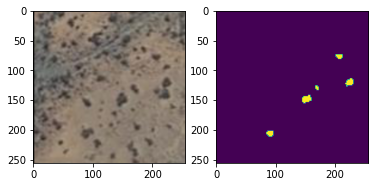

In [8]:
dataset.show_tuple(16)

# 2 Model

In [9]:
model_path = save_dir + "/" + model_name +  ".pth"
state_dict = torch.load(model_path,map_location="cpu")

In [10]:


if data_parallel:
    # create new OrderedDict that does not contain `module.`
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
    model_path = save_dir + "/" + model_name +  "_new.pth"
    torch.save(new_state_dict,model_path)
    

## 2.1 Advanced Unet

In [11]:
# Change here to adapt to your data
# n_channels=3 for RGB images 
# n_classes is the number of probabilities you want to get per pixel
if smp_model:
    net = smp.Unet(
        encoder_name="mit_b4",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=1,                      # model output channels (number of classes in your dataset)
    )
else:
    net = UNet(n_channels=3, n_classes=2, bilinear=False)
    #net= DataParallel(net)

if data_parallel:
    net.load_state_dict(new_state_dict)
else:
    net.load_state_dict(state_dict)
#net.load_state_dict(torch.load(model_path,map_location="cpu"))


#net= DataParallel(net,device_ids=[0,1])
net = net.to(device=device)

## 3 Validation

In [12]:
net.eval()
y_pred = torch.empty((len(dataset),256,256)).long()
start_idx = 0

with torch.no_grad(): 
    for i,batch in enumerate(test_dl):
        x = batch["x"]
        
        x = x.to(device)
        
        out = net(x)#["out"]
        
        if smp_model:
            probs = out.squeeze().sigmoid()
            out = (probs > 0.5).long().cpu()
        else:
            out = torch.argmax(out,dim=1)
            out = out.cpu()
            
        
        end_idx = start_idx + len(out)
        y_pred[start_idx:end_idx] = out
        start_idx += len(out)

In [13]:
dataset.evaluate(y_pred,model_name,save_dir=save_dir_output,
                 save_images=save_images,filter_true_empty=filter_true_empty);#,tmpdir="/tmp/test")

Model: smp_unet_mitb4_14_03_2023_144054
##############################
Year 2014: acc         0.976912
iou         0.365762
dice        0.411544
rmse_cov    0.012849
Number of patches: 100
##############################
Year 2015: acc         0.921774
iou         0.518875
dice        0.591396
rmse_cov    0.037518
Number of patches: 104
##############################
Year 2016: acc         0.923641
iou         0.458246
dice        0.542039
rmse_cov    0.040014
Number of patches: 260
##############################
Year 2017: acc         0.987147
iou         0.668292
dice        0.733066
rmse_cov    0.006282
Number of patches: 156
##############################
Year 2018: acc         0.925014
iou         0.394286
dice        0.457563
rmse_cov    0.051398
Number of patches: 136
##############################
Year 2019: acc         0.938067
iou         0.661947
dice        0.700943
rmse_cov    0.036359
Number of patches: 21

##############################
Total score: acc         0.943627
i

# Results

## Resampled

Model: smp_unet_mitb3_08_03_2023_170715
##############################
Year 2014: acc         0.983110
iou         0.468074
dice        0.510407
rmse_cov    0.010979
Number of patches: 100
##############################
Year 2015: acc         0.926421
iou         0.557678
dice        0.625352
rmse_cov    0.036528
Number of patches: 104
##############################
Year 2016: acc         0.933231
iou         0.536229
dice        0.619117
rmse_cov    0.033987
Number of patches: 260
##############################
Year 2017: acc         0.988522
iou         0.678915
dice        0.739486
rmse_cov    0.006117
Number of patches: 156
##############################
Year 2018: acc         0.935605
iou         0.442208
dice        0.507029
rmse_cov    0.041061
Number of patches: 136
##############################
Year 2019: acc         0.938864
iou         0.804467
dice        0.844079
rmse_cov    0.036327
Number of patches: 21

##############################
Total score: acc         0.950408
iou         0.549769
dice        0.616588
rmse_cov    0.027072

Model: unet_01_12_2022_085945
##############################
Year 2014: acc         0.982578
iou         0.410268
dice        0.455457
rmse_cov    0.008514
Number of patches: 100
##############################
Year 2015: acc         0.924169
iou         0.463246
dice        0.531892
rmse_cov    0.028078
Number of patches: 104
##############################
Year 2016: acc         0.929206
iou         0.518977
dice        0.600307
rmse_cov    0.033667
Number of patches: 260
##############################
Year 2017: acc         0.986868
iou         0.655881
dice        0.722339
rmse_cov    0.006400
Number of patches: 156
##############################
Year 2018: acc         0.926652
iou         0.406892
dice        0.470387
rmse_cov    0.048523
Number of patches: 136
##############################
Year 2019: acc         0.946504
iou         0.677118
dice        0.716360
rmse_cov    0.022217
Number of patches: 21

##############################
Total score: acc         0.946998
iou         0.509669
dice        0.577404
rmse_cov    0.026498

Model: smp_unet_mitb5_10_03_2023_091535
##############################
Year 2014: acc         0.980044
iou         0.443828
dice        0.483667
rmse_cov    0.008983
Number of patches: 100
##############################
Year 2015: acc         0.921419
iou         0.561933
dice        0.633178
rmse_cov    0.032133
Number of patches: 104
##############################
Year 2016: acc         0.927404
iou         0.536124
dice        0.616985
rmse_cov    0.037690
Number of patches: 260
##############################
Year 2017: acc         0.986018
iou         0.665145
dice        0.724854
rmse_cov    0.005976
Number of patches: 156
##############################
Year 2018: acc         0.917723
iou         0.419414
dice        0.482618
rmse_cov    0.056725
Number of patches: 136
##############################
Year 2019: acc         0.937614
iou         0.755195
dice        0.796272
rmse_cov    0.034096
Number of patches: 21

##############################
Total score: acc         0.943727
iou         0.539097
dice        0.604979
rmse_cov    0.030119

Model: smp_unet_mitb3_10_03_2023_123331
##############################
Year 2014: acc         0.982702
iou         0.277432
dice        0.323387
rmse_cov    0.010498
Number of patches: 100
##############################
Year 2015: acc         0.928998
iou         0.462886
dice        0.529906
rmse_cov    0.046579
Number of patches: 104
##############################
Year 2016: acc         0.927752
iou         0.430447
dice        0.505836
rmse_cov    0.050548
Number of patches: 260
##############################
Year 2017: acc         0.987152
iou         0.649326
dice        0.715453
rmse_cov    0.006697
Number of patches: 156
##############################
Year 2018: acc         0.921539
iou         0.382032
dice        0.445667
rmse_cov    0.055282
Number of patches: 136
##############################
Year 2019: acc         0.939004
iou         0.615527
dice        0.656927
rmse_cov    0.036535
Number of patches: 21

##############################
Total score: acc         0.946133
iou         0.455569
dice        0.521214
rmse_cov    0.036508

# No resampling

Model: smp_unet_mitb3_10_03_2023_092502
##############################
Year 2014: acc         0.986556
iou         0.408854
dice        0.433550
rmse_cov    0.004973
Number of patches: 25
##############################
Year 2015: acc         0.930121
iou         0.522447
dice        0.583900
rmse_cov    0.034044
Number of patches: 26
##############################
Year 2016: acc         0.935868
iou         0.511062
dice        0.588746
rmse_cov    0.039889
Number of patches: 65
##############################
Year 2017: acc         0.985868
iou         0.653433
dice        0.715385
rmse_cov    0.006533
Number of patches: 156
##############################
Year 2018: acc         0.923174
iou         0.421878
dice        0.486384
rmse_cov    0.051600
Number of patches: 136
##############################
Year 2019: acc         0.936807
iou         0.755796
dice        0.795750
rmse_cov    0.035720
Number of patches: 21

##############################
Total score: acc         0.952677
iou         0.541274
dice        0.603142
rmse_cov    0.028879

Model: smp_unet_mitb3_09_03_2023_145642
##############################
Year 2014: acc         0.986151
iou         0.395982
dice        0.414917
rmse_cov    0.005440
Number of patches: 25
##############################
Year 2015: acc         0.924707
iou         0.517244
dice        0.577558
rmse_cov    0.042104
Number of patches: 26
##############################
Year 2016: acc         0.936548
iou         0.522018
dice        0.600532
rmse_cov    0.038182
Number of patches: 65
##############################
Year 2017: acc         0.985578
iou         0.642676
dice        0.702409
rmse_cov    0.006144
Number of patches: 156
##############################
Year 2018: acc         0.916174
iou         0.427652
dice        0.491286
rmse_cov    0.060276
Number of patches: 136
##############################
Year 2019: acc         0.938939
iou         0.811099
dice        0.854397
rmse_cov    0.036745
Number of patches: 21

##############################
Total score: acc         0.950208
iou         0.542495
dice        0.603163
rmse_cov    0.031795

Model: smp_unet_mitb3_09_03_2023_181807
##############################
Year 2014: acc         0.986746
iou         0.416038
dice        0.447068
rmse_cov    0.008673
Number of patches: 25
##############################
Year 2015: acc         0.924383
iou         0.550466
dice        0.630284
rmse_cov    0.026353
Number of patches: 26
##############################
Year 2016: acc         0.934157
iou         0.512641
dice        0.598291
rmse_cov    0.038728
Number of patches: 65
##############################
Year 2017: acc         0.985335
iou         0.640847
dice        0.702217
rmse_cov    0.005929
Number of patches: 156
##############################
Year 2018: acc         0.917442
iou         0.403432
dice        0.466605
rmse_cov    0.055967
Number of patches: 136
##############################
Year 2019: acc         0.930586
iou         0.744232
dice        0.784203
rmse_cov    0.043555
Number of patches: 21

##############################
Total score: acc         0.949766
iou         0.532640
dice        0.596563
rmse_cov    0.030001

Model: smp_unet_mitb3_08_03_2023_170715
##############################
Year 2014: acc     0.987480
iou     0.394560
dice    0.413759
Number of patches: 25
##############################
Year 2015: acc     0.930509
iou     0.525148
dice    0.586879
Number of patches: 26
##############################
Year 2016: acc     0.940023
iou     0.520603
dice    0.597100
Number of patches: 65
##############################
Year 2017: acc     0.988522
iou     0.678915
dice    0.739486
Number of patches: 156
##############################
Year 2018: acc     0.935604
iou     0.442207
dice    0.507028
Number of patches: 136
##############################
Year 2019: acc     0.938865
iou     0.804471
dice    0.844084
Number of patches: 21

##############################
Total score: acc     0.958391
iou     0.560144
dice    0.621109

Model: smp_unet_mitb3_08_03_2023_141120
##############################
Year 2014: acc     0.985440
iou     0.453480
dice    0.487964
Number of patches: 25
##############################
Year 2015: acc     0.928016
iou     0.542908
dice    0.615418
Number of patches: 26
##############################
Year 2016: acc     0.938692
iou     0.544327
dice    0.630902
Number of patches: 65
##############################
Year 2017: acc     0.986604
iou     0.662620
dice    0.725944
Number of patches: 156
##############################
Year 2018: acc     0.923567
iou     0.420720
dice    0.484215
Number of patches: 136
##############################
Year 2019: acc     0.939119
iou     0.805067
dice    0.846973
Number of patches: 21

##############################
Total score: acc     0.953418
iou     0.555540
dice    0.620269

Model: smp_unet_mitb407_03_2023_160548
##############################
Year 2014: acc     0.986929
iou     0.415253
dice    0.448494
Number of patches: 25
##############################
Year 2015: acc     0.930984
iou     0.550996
dice    0.626585
Number of patches: 26
##############################
Year 2016: acc     0.938565
iou     0.516481
dice    0.597553
Number of patches: 65
##############################
Year 2017: acc     0.988316
iou     0.659418
dice    0.720895
Number of patches: 156
##############################
Year 2018: acc     0.934447
iou     0.417224
dice    0.481901
Number of patches: 136
##############################
Year 2019: acc     0.933922
iou     0.794816
dice    0.832841
Number of patches: 21

##############################
Total score: acc     0.957482
iou     0.546810
dice    0.610332

Model: unet_01_12_2022_085945
##############################
Year 2014: acc         0.986035
iou         0.461193
dice        0.496503
rmse_cov    0.005842
Number of patches: 25
##############################
Year 2015: acc         0.922195
iou         0.517196
dice        0.594247
rmse_cov    0.023179
Number of patches: 26
##############################
Year 2016: acc         0.936397
iou         0.531913
dice        0.618776
rmse_cov    0.035135
Number of patches: 65
##############################
Year 2017: acc         0.986868
iou         0.655881
dice        0.722339
rmse_cov    0.006400
Number of patches: 156
##############################
Year 2018: acc         0.926652
iou         0.406892
dice        0.470387
rmse_cov    0.048523
Number of patches: 136
##############################
Year 2019: acc         0.946504
iou         0.677118
dice        0.716360
rmse_cov    0.022217
Number of patches: 21

##############################
Total score: acc         0.954188
iou         0.539454
dice        0.605558
rmse_cov    0.025866

Model: unet_18_11_2022_103158
##############################
Year 2014: acc         0.984965
iou         0.435279
dice        0.483363
rmse_cov    0.005641
Number of patches: 25
##############################
Year 2015: acc         0.921050
iou         0.513765
dice        0.591256
rmse_cov    0.023895
Number of patches: 26
##############################
Year 2016: acc         0.935577
iou         0.546516
dice        0.634321
rmse_cov    0.034811
Number of patches: 65
##############################
Year 2017: acc         0.985821
iou         0.615769
dice        0.678397
rmse_cov    0.006992
Number of patches: 156
##############################
Year 2018: acc         0.927065
iou         0.398239
dice        0.461882
rmse_cov    0.048929
Number of patches: 136
##############################
Year 2019: acc         0.940179
iou         0.661599
dice        0.703075
rmse_cov    0.028234
Number of patches: 21

##############################
Total score: acc         0.953372
iou         0.521859
dice        0.587641
rmse_cov    0.026487

In [14]:
dataset.evaluate(y_pred,model_name,save_dir=save_dir_output,
                 save_images=save_images,filter_true_empty=filter_true_empty);#,tmpdir="/tmp/test")

Model: unet_01_12_2022_085945
##############################
Year 2014: acc     0.986035
iou     0.461193
dice    0.496503
Number of patches: 25
##############################
Year 2015: acc     0.922195
iou     0.517196
dice    0.594247
Number of patches: 26
##############################
Year 2016: acc     0.936397
iou     0.531913
dice    0.618776
Number of patches: 65
##############################
Year 2018: acc     0.926652
iou     0.406892
dice    0.470387
Number of patches: 136
##############################
Year 2019: acc     0.946504
iou     0.677118
dice    0.716360
Number of patches: 21

##############################
Total score: acc     0.935513
iou     0.472923
dice    0.538827


In [14]:
dataset.evaluate(y_pred,model_name,save_dir=save_dir_output,
                 save_images=save_images,filter_true_empty=filter_true_empty);#,tmpdir="/tmp/test")

Model: unet_15_12_2022_111006
##############################
Year 2014: acc     0.987191
iou     0.436878
dice    0.460739
Number of patches: 25
##############################
Year 2015: acc     0.928354
iou     0.503438
dice    0.564688
Number of patches: 26
##############################
Year 2016: acc     0.936648
iou     0.542543
dice    0.621550
Number of patches: 65
##############################
Year 2018: acc     0.932991
iou     0.390925
dice    0.455245
Number of patches: 136
##############################
Year 2019: acc     0.935765
iou     0.706037
dice    0.743146
Number of patches: 21

##############################
Total score: acc     0.938597
iou     0.466188
dice    0.527914
